In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import timeit
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

## Read MNIST Data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
(mnist.train.images).ndim

2

In [4]:
mnist.train.labels[0:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

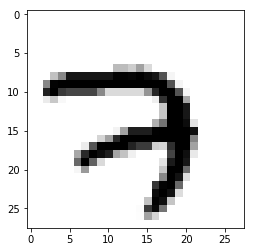

In [5]:
plt.imshow(mnist.train.images[0].reshape((28,28)), cmap=cm.Greys)

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 784], name = "x")
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y_")

# Convolutional Neural Net

2D convolution
* http://www.songho.ca/dsp/convolution/convolution2d_example.html

In [4]:
# Node definition functions

def weight_variable(shape):
    # non-zero intial value for symmetry breaking
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], 
                         strides=[1,2,2,1], padding="SAME")

## Define Layers

In [5]:
# 1st Convolutional layer
# For each 5x5 patch, compute 32 features
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [6]:
# 2nd Convolutional Layer

# 64 features for each 5x5 patch
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [7]:
# Densely connected layer
# Image has been reduced to a 7x7 feature image in the pooling layer
# add a fully -connected layer of 1024 neurons to process image
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [8]:
# Dropout layer
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [9]:
# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2, name="y_conv") + b_fc2

In [10]:
# Variables for evaluation
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [11]:
# Variables for visualization
accuracy_summary = tf.summary.scalar("accuracy", accuracy)

# Train model

In [12]:
# initialize timers, file paths
startTime = timeit.default_timer()
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = 'c:/tmp/logdir'
logdir = "{}/run={}".format(root_logdir, now)
modeldir = "/tmp/models/model_gpu.ckpt"

# Set up save and write utilities
saver =tf.train.Saver()

In [13]:
with tf.Session() as sess:
    
    # Write graph log for tensorBoard
    summary = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(logdir, sess.graph)
    print("Writing tensorboard events to: %s" % logdir)
    
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
              x: batch[0], y_: batch[1], keep_prob: 1.0})
            
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        
        summary = train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
        if i % 100 == 0:
            # write logs
            summary_writer.add_summary(summary, i)
            
    # Evaluate
    # out of memory when evaluating the entire test set at once
#   print('test accuracy %g' % accuracy.eval(feed_dict={
#       x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    # Evaluate accuracy in Batches and average the result instead
    batch_size = 50
    batch_num = int(mnist.test.num_examples / batch_size)
    test_accuracy = 0

    for i in range(batch_num):
        batch = mnist.test.next_batch(batch_size)
        test_accuracy += accuracy.eval(feed_dict={x: batch[0],
                                                  y_: batch[1],
                                                  keep_prob: 1.0})

    test_accuracy /= batch_num
    print("test accuracy %g" % test_accuracy)
    
    # Save model to disk
    save_path = saver.save(sess, modeldir)
    print("Trained model saved to %s" % save_path)
    
    # shutdown objects
    summary_writer.close()

endTime = timeit.default_timer()
print("Ran for %f seconds, or  %f minutes" % (endTime - startTime, (endTime - startTime) / 60.0))

Writing tensorboard events to: c:/tmp/logdir/run=20170713012222
step 0, training accuracy 0.06
step 100, training accuracy 0.8
step 200, training accuracy 0.96
step 300, training accuracy 0.88
step 400, training accuracy 0.9
step 500, training accuracy 0.96
step 600, training accuracy 0.98
step 700, training accuracy 0.98
step 800, training accuracy 0.94
step 900, training accuracy 0.94
step 1000, training accuracy 0.98
step 1100, training accuracy 0.96
step 1200, training accuracy 1
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.98
step 1700, training accuracy 1
step 1800, training accuracy 0.94
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 1
step 2200, training accuracy 0.98
step 2300, training accuracy 1
step 2400, training accuracy 0.96
step 2500, training accuracy 1
step 2600, training accuracy 1
step 2700, training accuracy 0.98
step 2800, training accur

### Run Tensorboard

In [27]:
# Run tensorBoard, does not work in cygwin, must be cmd
#  tensorboard --logdir c:\tmp\logDir

# Then navigate browser to url "http://ulric-desktop:6006"